## Анализ результатов эксперимента

Проанализируем результаты эксперимента, который проходил с 2023-01-01 по 2023-01-07 включительно. Для эксперимента были задействованы 1 и 2 группы. В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.  
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.  
Сравним CTR двух групп различными тестами.

1. Подключаемся к базе данных

In [1]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230120',
                      'user':'student', 
                      'password':'dpo_python_2020'
             }

2. Импортируем нужные библиотеки

In [2]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
%matplotlib inline

3. Формируем общий dataframe и передаём переменным строки, соответствуюшие группе пользователей

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') AS likes,
    sum(action = 'view') AS views,
    likes/views AS ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2023-01-01' AND '2023-01-07'
  AND exp_group IN (1, 2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

group_A = df[df.exp_group == 1].copy()
group_B = df[df.exp_group == 2].copy()

In [4]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


4. Построим гистограмму распределения CTR в группах A и B.

<AxesSubplot:xlabel='ctr', ylabel='Count'>

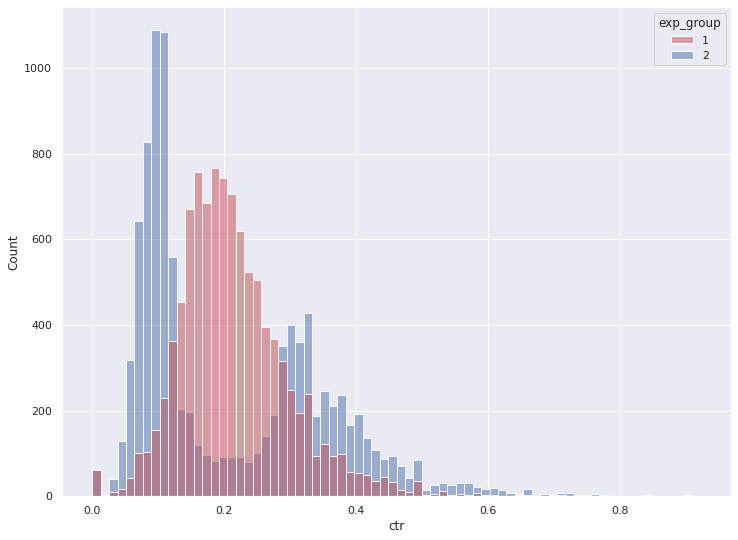

In [5]:
sns.set(rc={'figure.figsize':(12, 9)})

sns.histplot(data=df, 
              x='ctr', 
              hue='exp_group', 
              palette=['r', 'b'],
              alpha=0.5,
              kde=False)

Судя по графику, распределение CTR в первой (контрольной) группе похоже на унимодальное, а во второй - на бимодальное.
Мы видим, что у большего числа пользователей второй группы CTR уменьшился.
Вероятно, причина в том, что не всем пользователям понравилась работа нового алгоритма, 
не на всех он сработал так, как было задумано.

5. Применим t-тест

In [6]:
stats.ttest_ind(group_A.ctr, group_B.ctr, equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [7]:
group_A.ctr.mean(), group_B.ctr.mean()

(0.21560459841296287, 0.21441927347479375)

t-тест не показывает статистически значимых различий CTR между двумя выборками (p-value > 0.05), 
так как, несмотря на разное распределение, средние значения CTR двух групп примерно одинаковы.

6. Применим тест Манна-Уитни

In [8]:
stats.mannwhitneyu(group_A.ctr, 
                   group_B.ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна-Уитни показал, что различия есть (p-value < 0.05)

7. Применим t-тест на сглаженном CTR

In [9]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

global_ctr_A = group_A.likes.sum() / group_A.views.sum()
global_ctr_B = group_B.likes.sum() / group_B.views.sum()

group_A['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_A, 5), axis=1)
group_B['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_B, 5), axis=1)

stats.ttest_ind(group_A.smoothed_ctr,
                group_B.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

После сглаживания CTR t-тест показал, что различия есть (p-value < 0.05)

8. Применим пуассоновский bootstrap

In [10]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes_A = group_A.likes.to_numpy()
views_A = group_A.views.to_numpy()
likes_B = group_B.likes.to_numpy()
views_B = group_B.views.to_numpy()

ctr_A, ctr_B = bootstrap(likes_A, views_A, likes_B, views_B)

8.1. Построим гистограмму распределения CTR в группах A и B после применения функции

<AxesSubplot:ylabel='Count'>

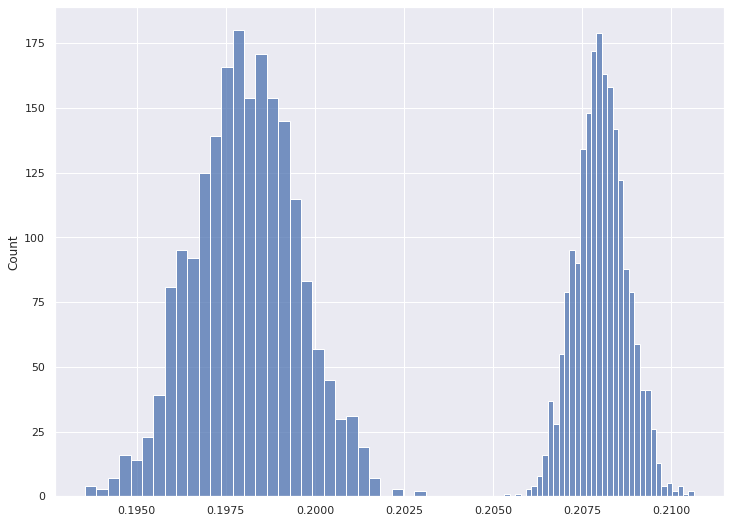

In [11]:
sns.histplot(ctr_A)
sns.histplot(ctr_B)

График показывает, что различия между группами есть

8.2. Построим гистограмму распределения разницы между глобальными CTR двух групп

<AxesSubplot:ylabel='Count'>

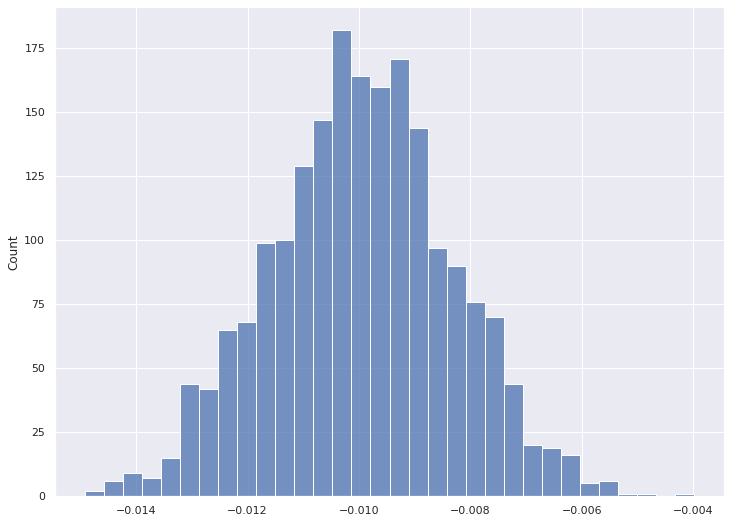

In [12]:
sns.histplot(ctr_B - ctr_A)

График распределения не пересекает ноль, следовательно, различия между группами статистически значимы.
Значения на графике отрицательные, следовательно, глобальный CTR во группе B (тестовой) меньше, чем в группе A (контрольной).

9. Применим бакетное преобразование

In [13]:
q_bucket = """
SELECT exp_group, bucket,
       sum(likes)/sum(views) AS bucket_ctr,
       quantileExact(0.9)(ctr) AS ctr9
  FROM (SELECT exp_group, 
               xxHash64(user_id)%50 AS bucket,
               user_id,
               sum(action = 'like') AS likes,
               sum(action = 'view') AS views,
               likes/views AS ctr
          FROM {db}.feed_actions 
         WHERE toDate(time) BETWEEN '2023-01-01' AND '2023-01-07'
           AND exp_group IN (1, 2)
      GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q_bucket, connection=connection)

9.1. Применим t-тест после бакетного преобразования

In [14]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

t-тест поверх бакетного преобразования показал, что различия есть (p-value < 0.05)

9.2. Применим тест Манна-Уитни после бакетного преобразования

In [15]:
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Тест Манна-Уитни поверх бакетного преобразования показал, что различия есть (p-value < 0.05)

9.3. Построим гистограмму распределения CTR в группах A и B после бакетного преобразования

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

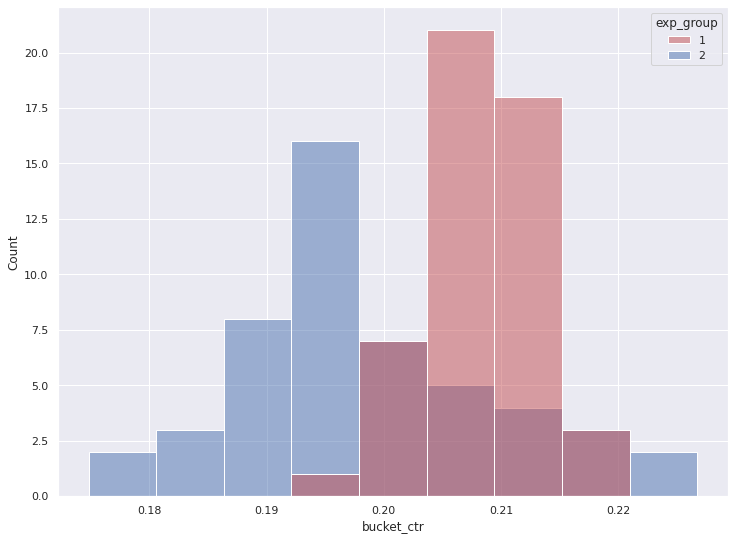

In [16]:
sns.histplot(data=df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette=['r', 'b'],
              alpha=0.5,
              kde=False)

In [17]:
df_bucket[df_bucket.exp_group == 1].bucket_ctr.mean(), df_bucket[df_bucket.exp_group == 2].bucket_ctr.mean()

(0.20812170724336013, 0.19825944666552928)

Средний CTR после бакетного преобразования во второй группе (тестовой) меньше, чем в первой (контрольной)

### Вывод

При анализе данных хуже всего показал себя t-тест, остальные тесты показали статистически значимые различия между группами A и B.
Пуассоновский бутстреп показал отрицательное влияние нововведений на измеряемую метрику, поэтому новый алгоритм применять не рекомендуется.